In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()
spark

In [3]:
json_lzo = sc.newAPIHadoopFile("s3://bigdatateaching/reddit/lzo/RC_*.lzo", "com.hadoop.mapreduce.LzoTextInputFormat",
                               "org.apache.hadoop.io.LongWritable", "org.apache.hadoop.io.Text")

In [4]:
data = spark.read.json("s3://bigdatateaching/reddit/sample-data/1m-line-sample.json")
schema = data.schema.json()
from pyspark.sql.types import *
import json
new_schema = StructType.fromJson(json.loads(schema))
new_schema

StructType(List(StructField(archived,BooleanType,true),StructField(author,StringType,true),StructField(author_cakeday,BooleanType,true),StructField(author_created_utc,LongType,true),StructField(author_flair_background_color,StringType,true),StructField(author_flair_css_class,StringType,true),StructField(author_flair_richtext,ArrayType(StructType(List(StructField(a,StringType,true),StructField(e,StringType,true),StructField(t,StringType,true),StructField(u,StringType,true))),true),true),StructField(author_flair_template_id,StringType,true),StructField(author_flair_text,StringType,true),StructField(author_flair_text_color,StringType,true),StructField(author_flair_type,StringType,true),StructField(author_fullname,StringType,true),StructField(author_patreon_flair,BooleanType,true),StructField(body,StringType,true),StructField(can_gild,BooleanType,true),StructField(can_mod_post,BooleanType,true),StructField(collapsed,BooleanType,true),StructField(collapsed_reason,StringType,true),StructFiel

In [5]:
from pyspark.sql import Row
import pyspark.sql.functions as F

data = json_lzo.map(lambda x:Row(x[1])).toDF(['raw']).select(F.from_json('raw',new_schema).alias('json')).select('json.*')

In [6]:
data.count()

476259744

Randomly sample 10 million rows from the dataset

In [8]:
fraction = 10000000 / 470000000
data_1m = data.sample(False, fraction, 100)
data_1m.write.parquet("s3://secondhandbigdata/project/data_1m")

Load sampled dataset (data_1m)

In [9]:
data = spark.read.format('parquet').option('header', 'true').option('inferSchema', 'true').load('s3://secondhandbigdata/project/data_1m')

In [10]:
import datetime
timestart = datetime.datetime.now()

#get rid of 'deleted users', since they do not have value anymore
data = data.where(data['author'] != '[deleted]')

#Assigning Unique value ('U') to Nan values   
data = data.na.fill('U')

#Convert boolean type columns into numerical
data = data.withColumn('archived', F.when(F.col('archived') == False, 0).otherwise(1))
data = data.withColumn('can_gild', F.when(F.col('can_gild') == False, 0).otherwise(1))
data = data.withColumn('can_mod_post', F.when(F.col('can_mod_post') == False, 0).otherwise(1))
data = data.withColumn('collapsed', F.when(F.col('collapsed') == False, 0).otherwise(1))
data = data.withColumn('is_submitter', F.when(F.col('is_submitter') == False, 0).otherwise(1))
data = data.withColumn('no_follow', F.when(F.col('no_follow') == False, 0).otherwise(1))
data = data.withColumn('send_replies', F.when(F.col('send_replies') == False, 0).otherwise(1))
data = data.withColumn('stickied', F.when(F.col('stickied') == False, 0).otherwise(1))
data = data.withColumn('edited', F.when(F.col('edited') == False, 0).otherwise(1))

#select only the features which would be used
selectCol = ['author', 'created_utc', 'subreddit', 'archived', 'author_created_utc', 'body', 'can_gild', 'can_mod_post',
            'collapsed', 'controversiality', 'edited', 'gilded', 'is_submitter', 'no_follow', 'retrieved_on', 
            'score', 'send_replies', 'stickied', 'subreddit_type']
data = data.select(selectCol)

data.show(10)

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

+-----------------+-----------+--------------------+--------+------------------+--------------------+--------+------------+---------+----------------+------+------+------------+---------+------------+-----+------------+--------+--------------+
|           author|created_utc|           subreddit|archived|author_created_utc|                body|can_gild|can_mod_post|collapsed|controversiality|edited|gilded|is_submitter|no_follow|retrieved_on|score|send_replies|stickied|subreddit_type|
+-----------------+-----------+--------------------+--------+------------------+--------------------+--------+------------+---------+----------------+------+------+------------+---------+------------+-----+------------+--------+--------------+
|        loop2loop| 1542977653|           AskReddit|       0|        1500159331|American exceptio...|       1|           0|        0|               0|     0|     0|           0|        1|  1545939501|  530|           1|       0|        public|
|        metalman7| 1542

Store cleaned data

In [11]:
import datetime
timestart = datetime.datetime.now()

data.write.parquet("s3://secondhandbigdata/project/data_1m_cleaned")

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

Time taken to execute above cell: 71.943647seconds


Load cleaned data (data_1m_cleaned)

In [12]:
data_1 = spark.read.format('parquet').option('header', 'true').option('inferSchema', 'true').load('s3://secondhandbigdata/project/data_1m_cleaned')

GROUP, SELECT, JOIN, nitty gritty
Step 1

In [13]:
import datetime
timestart = datetime.datetime.now()

data_1.createOrReplaceTempView("data_1")
#only pick the first subreddit the author posted in if the author posted multiple at the same time
data_2 = spark.sql('''
                    SELECT author, created_utc, FIRST(subreddit) subreddit
                    FROM data_1
                    GROUP BY author, created_utc
                ''').cache()

data_2.show(10)

data_2.write.parquet("s3://secondhandbigdata/project/data_1m_step1")

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

+--------------------+-----------+-----------------+
|              author|created_utc|        subreddit|
+--------------------+-----------+-----------------+
|---TheFierceDeity---| 1541660669|         Warframe|
| ---midnight_rain---| 1547142496|          Calgary|
|            --Anna--| 1545055615|        AskReddit|
|          --cheese--| 1548448216|     circlebroke2|
|           --chino--| 1544232670|           GCXRep|
|                -0_0| 1540798839|           gaming|
|               -100K| 1544229608|    TheMonkeysPaw|
|               -4-a-| 1544347750|      Cringetopia|
|               -500-| 1540582076|      advertising|
|                -86-| 1548566891|NoStupidQuestions|
+--------------------+-----------+-----------------+
only showing top 10 rows

Time taken to execute above cell: 25.322017seconds


Load data_2 (data_1m_step2)

In [14]:
data_2 = spark.read.format('parquet').option('header', 'true').option('inferSchema', 'true').load('s3://secondhandbigdata/project/data_1m_step1')

Step 2

In [15]:
import datetime
timestart = datetime.datetime.now()

data_2.createOrReplaceTempView("data_2")
data_3 = spark.sql('''
                    SELECT d1.author author, d1.created_utc current_post_time, 
                    MIN(d2.created_utc) next_post_time
                    FROM data_2 d1
                        LEFT JOIN data_2 d2
                        ON d1.author = d2.author
                    WHERE d1.created_utc < d2.created_utc
                    GROUP BY d1.author, d1.created_utc
                ''')

data_3.show(10)

data_3.write.parquet("s3://secondhandbigdata/project/data_1m_step2")

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

+-----------+-----------------+--------------+
|     author|current_post_time|next_post_time|
+-----------+-----------------+--------------+
|    ---NoTy|       1544778710|    1546371574|
|    ---NoTy|       1546411575|    1546601980|
|    ---NoTy|       1546601980|    1547627780|
|    ---NoTy|       1548095346|    1548111234|
|    ---NoTy|       1547627780|    1548095346|
|    ---NoTy|       1546404679|    1546411575|
|    ---NoTy|       1546371574|    1546404679|
|  -Coltaine|       1540872708|    1540925144|
|-Degaussed-|       1547142437|    1547695395|
|-Degaussed-|       1538673815|    1539102694|
+-----------+-----------------+--------------+
only showing top 10 rows

Time taken to execute above cell: 919.505607seconds


Load data_3 (data_1m_step3)

In [16]:
data_3 = spark.read.format('parquet').option('header', 'true').option('inferSchema', 'true').load('s3://secondhandbigdata/project/data_1m_step2')

Step 3

In [17]:
import datetime
timestart = datetime.datetime.now()

data_3.createOrReplaceTempView("data_3")
data_4 = spark.sql('''
                    SELECT d1.author author, d1.current_post_time current_post_time, d1.next_post_time next_post_time,
                    d2.subreddit current_subreddit, d3.subreddit next_subreddit,
                        d2.archived archived, d2.author_created_utc author_created_utc, 
                        d2.body body, d2.can_gild can_gild, d2.can_mod_post can_mod_post, 
                        d2.collapsed collapsed, d2.controversiality controversiality, 
                        d2.edited edited, d2.gilded gilded,
                        d2.is_submitter is_submitter, d2.no_follow no_follow, 
                        d2.retrieved_on retrieved_on, d2.score score, d2.send_replies send_replies, 
                        d2.stickied stickied, d2.subreddit_type subreddit_type
                    FROM data_3 d1
                        LEFT JOIN data_1 d2
                        ON d1.author = d2.author AND d1.current_post_time = d2.created_utc
                        LEFT JOIN data_1 d3
                        ON d1.author = d3.author AND d1.next_post_time = d3.created_utc
                ''')

data_4.show(10)

data_4.write.parquet("s3://secondhandbigdata/project/data_1m_step3")

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

+--------------------+-----------------+--------------+-----------------+--------------+--------+------------------+--------------------+--------+------------+---------+----------------+------+------+------------+---------+------------+-----+------------+--------+--------------+
|              author|current_post_time|next_post_time|current_subreddit|next_subreddit|archived|author_created_utc|                body|can_gild|can_mod_post|collapsed|controversiality|edited|gilded|is_submitter|no_follow|retrieved_on|score|send_replies|stickied|subreddit_type|
+--------------------+-----------------+--------------+-----------------+--------------+--------+------------------+--------------------+--------+------------+---------+----------------+------+------+------------+---------+------------+-----+------------+--------+--------------+
|---TheFierceDeity---|       1541386955|    1541660669|              aww|      Warframe|       0|        1427890367|marsupial ~~rat~~...|       1|           0| 

Load data_4 (data_1m_step3)

In [3]:
data_df = spark.read.format('parquet').option('header', 'true').option('inferSchema', 'true').load('s3://secondhandbigdata/project/data_1m_step3')

In [4]:
#drop na
data_df = data_df.na.drop()

In [6]:
data_df.describe().show()

+-------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------------+------------------+--------------------+--------------+
|summary|              author|   current_post_time|     next_post_time|   current_subreddit|      next_subreddit|           archived|  author_created_utc|    body|           can_gild|can_mod_post|           collapsed|    controversiality|              edited|              gilded|       is_submitter|         no_follow|        retrieved_on|             score|      send_replies|            stickied|subreddit_type|
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------+-------

Use pandas to make graphs

In [6]:
data_pd_df = data_df.limit(100000).toPandas()

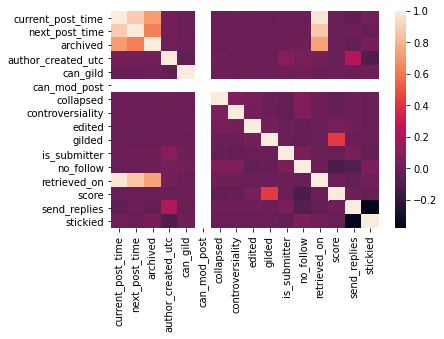

In [7]:
import seaborn as sns
%matplotlib inline

corr = data_pd_df.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

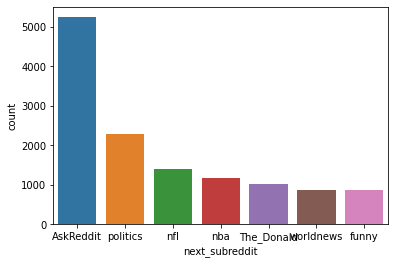

In [20]:
sns.countplot(x="next_subreddit", data=data_pd_df, order=data_pd_df.next_subreddit.value_counts().iloc[:7].index)

In [14]:
def predictNextPostTime(columnName):
    from pyspark.ml.feature import VectorAssembler
    prCol = ['current_post_time', 'archived', 'retrieved_on']

    vectorAssembler = VectorAssembler(inputCols = prCol, outputCol = 'features')
    vdata_df = vectorAssembler.transform(data_df)
    
    train_df, test_df = vdata_df.randomSplit([0.7, 0.3], 100)
    print('-----------------------------------------------')
    print("Number of training records: ", train_df.count())
    print("Number of testing records : ", test_df.count())
    
    from pyspark.ml.regression import LinearRegression
    lr = LinearRegression(featuresCol = 'features', labelCol=columnName, maxIter=40, regParam=0.6, elasticNetParam=0.6)
    lr_model = lr.fit(train_df)
    #print("Coefficients: " + str(lr_model.coefficients))
    #print("Intercept: " + str(lr_model.intercept))
    
    trainingSummary = lr_model.summary
    print('-----------------------------------------------')
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)
    
    lr_predictions = lr_model.transform(test_df)
    from pyspark.ml.evaluation import RegressionEvaluator
    lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=columnName, metricName="r2")
    print('-----------------------------------------------')
    print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))
    
    test_result = lr_model.evaluate(test_df)
    print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)
    
    #print("numIterations: %d" % trainingSummary.totalIterations)
    #print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
    #trainingSummary.residuals.show()
    
    print('-----------------------------------------------')
    predictions = lr_model.transform(test_df)
    predictions.select("prediction",columnName,"features").show()

In [15]:
import datetime
timestart = datetime.datetime.now()

predictNextPostTime('next_post_time')

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

-----------------------------------------------
Number of training records:  18232275
Number of testing records :  7812770
-----------------------------------------------
RMSE: 1369265.547406
r2: 0.781717
-----------------------------------------------
R Squared (R2) on test data = 0.781991
Root Mean Squared Error (RMSE) on test data = 1.36832e+06
-----------------------------------------------
+--------------------+--------------+--------------------+
|          prediction|next_post_time|            features|
+--------------------+--------------+--------------------+
|1.5483137741088765E9|    1548369936|[1.548096415E9,1....|
| 1.545978059971857E9|    1545266512|[1.545266414E9,0....|
| 1.545978059971857E9|    1545266512|[1.545266414E9,0....|
| 1.545978059971857E9|    1545266512|[1.545266414E9,0....|
|1.5425009890438209E9|    1542840143|[1.541086767E9,0....|
|1.5451428507458239E9|    1545189283|[1.54422644E9,0.0...|
|1.5451428507458239E9|    1545189283|[1.54422644E9,0.0...|
|1.545142850

Linear Regression, Predict score and next_post_time

Classification, predict next_subreddit

In [5]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

def getTrainTest(data_df):
    import datetime
    timestart = datetime.datetime.now()

    stages = []

    from pyspark.ml.feature import Tokenizer

    tokenizer = Tokenizer(inputCol = "body", outputCol = "words")
    #wordsDataFrame = tokenizer.transform(data_df)

    stages += [tokenizer]
    
    #convert and encode the categorical features
    categoricalColumns = ['subreddit_type', 'current_subreddit']
    
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_idx')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_class_vec"])
        stages += [stringIndexer, encoder]
        
    label_stringIdx = StringIndexer(inputCol = 'next_subreddit', outputCol = 'label')
    stages += [label_stringIdx]

    #conbine both categorical and numerical features
    numericCols = ['current_post_time', 'score', 'archived', 'author_created_utc', 'can_gild', 'can_mod_post', 'collapsed', 
                   'gilded', 'is_submitter', 'no_follow', 'retrieved_on', 'send_replies', 'stickied', 'edited', 'controversiality']

    assemblerInputs = [c + "_class_vec" for c in categoricalColumns] + numericCols + ['words']
    assemblerInputs = numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(data_df)
    mdata_df = pipelineModel.transform(data_df)
    
    train_df, test_df = mdata_df.randomSplit([0.7, 0.3], 2020)

    print("Number of training records: " + str(train_df.count()))
    print("Number of testing records : " + str(test_df.count()))

    timeend = datetime.datetime.now()
    timedelta = (timeend-timestart).total_seconds() 
    print("Time taken to get train and test: " + str(timedelta) + "seconds")
    
    return mdata_df, train_df, test_df

In [6]:
mdata_df, train_df, test_df = getTrainTest(data_df)

Number of training records: 18232247
Number of testing records : 7812798
Time taken to get train and test: 215.565262seconds


In [17]:
train_df.show(1)

+-------------------+-----------------+--------------+-----------------+---------------+--------+------------------+--------------------+--------+------------+---------+----------------+------+------+------------+---------+------------+-----+------------+--------+--------------+--------------------+------------------+------------------------+---------------------+---------------------------+-----+--------------------+
|             author|current_post_time|next_post_time|current_subreddit| next_subreddit|archived|author_created_utc|                body|can_gild|can_mod_post|collapsed|controversiality|edited|gilded|is_submitter|no_follow|retrieved_on|score|send_replies|stickied|subreddit_type|               words|subreddit_type_idx|subreddit_type_class_vec|current_subreddit_idx|current_subreddit_class_vec|label|            features|
+-------------------+-----------------+--------------+-----------------+---------------+--------+------------------+--------------------+--------+----------

Make graph with pandas

In [7]:
import datetime
timestart = datetime.datetime.now()
    
train_pd_df = train_df.limit(1000).toPandas()
train_pd_df = train_pd_df[['current_post_time', 'next_post_time', 'next_subreddit', 'archived', 'author_created_utc','can_gild','can_mod_post', 'collapsed', 'controversiality', 
                          'edited', 'gilded', 'is_submitter', 'no_follow', 'retrieved_on', 'score', 'send_replies', 'stickied','subreddit_type_idx', 'current_subreddit_idx', 'label']]

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to get train and test: " + str(timedelta) + "seconds")

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


Time taken to get train and test: 143.784232seconds


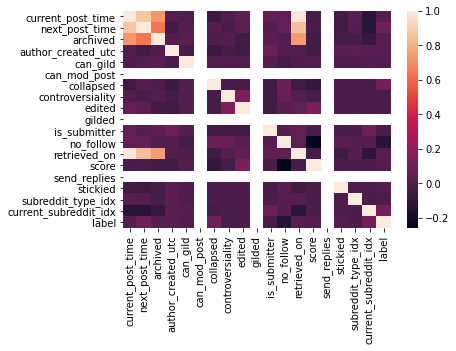

In [8]:
import seaborn as sns
%matplotlib inline

corr = train_pd_df.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Logistic regression

In [21]:
import datetime
timestart = datetime.datetime.now()

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=25)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(test_df)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Area Under the Curve for LogisticRegression:', evaluator.evaluate(predictions))

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

Area Under the Curve for LogisticRegression: 0.43569148936170216
Time taken to execute above cell: 331.153202seconds


In [22]:
lrModel.write().overwrite().save("s3://secondhandbigdata/project/models/lrModel")

Random forest classifier

In [9]:
import datetime
timestart = datetime.datetime.now()

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_df.limit(1000))
predictions = rfModel.transform(test_df.limit(1000))
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Area Under the Curve for RandomForestClassifier: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

Area Under the Curve for RandomForestClassifier: 0.5423082787010215
Time taken to execute above cell: 295.300517seconds


In [ ]:
rfModel.write().overwrite().save("s3://secondhandbigdata/project/models/rfModel")

Dicision tree classifer

In [8]:
import datetime
timestart = datetime.datetime.now()

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 20)
dtModel = dt.fit(train_df)
predictions = dtModel.transform(test_df)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Area Under the Curve for DecisionTreeClassifier: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

timeend = datetime.datetime.now()
timedelta = (timeend-timestart).total_seconds() 
print("Time taken to execute above cell: " + str(timedelta) + "seconds")

Area Under the Curve for DecisionTreeClassifier: 0.511411889596603
Time taken to execute above cell: 1118.285272seconds


In [10]:
dtModel.write().overwrite().save("s3://secondhandbigdata/project/models/dtModel")

In [13]:
sc.stop()
spark.stop()